In [0]:
pip install imblearn


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install mlflow

Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-ff44738b-46b9-4c79-81ca-dd728ea0c82a
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-ff44738b-46b9-4c79-81ca-dd728ea0c82a
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-ff44738b-46b9-4c79-81ca-dd728ea0c82a
  

In [0]:
pip install catboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install lightgbm

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
pip install xgboost

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/X_pca.parquet/', name='X_pca.parquet/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/data_descriptions.csv', name='data_descriptions.csv', size=2001, modificationTime=1711807190000),
 FileInfo(path='dbfs:/FileStore/tables/prediction_submission.csv', name='prediction_submission.csv', size=1567233, modificationTime=1711807190000),
 FileInfo(path='dbfs:/FileStore/tables/test.csv', name='test.csv', size=15055101, modificationTime=1711807193000),
 FileInfo(path='dbfs:/FileStore/tables/train.csv', name='train.csv', size=43346213, modificationTime=1711807199000),
 FileInfo(path='dbfs:/FileStore/tables/transformed_df.parquet/', name='transformed_df.parquet/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/transformed_df_new.parquet/', name='transformed_df_new.parquet/', size=0, modificationTime=0)]

In [0]:
import pyspark.pandas as ps

# Read the file directly into a pandas-on-Spark DataFrame
train_spark_df = ps.read_csv("/FileStore/tables/train.csv")
test_spark_df = ps.read_csv("/FileStore/tables/test.csv")
prediction_spark_df = ps.read_csv("/FileStore/tables/prediction_submission.csv")

# If needed, convert to a Pandas DataFrame
train_df = train_spark_df.to_pandas()
test_df = test_spark_df.to_pandas()
prediction_df= prediction_spark_df.to_pandas()

In [0]:
print('train_df Shape:', train_df.shape)
print('test_df Shape:', test_df.shape)

train_df Shape: (243787, 21)
test_df Shape: (104480, 20)


In [0]:
# Import required packages
# Data packages
import pandas as pd
import numpy as np

# Machine Learning / Classification packages
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

# Visualization Packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder, Normalizer


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for encoding categorical columns
class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns, subscription_type_ordering):
        self.categorical_columns = categorical_columns
        self.subscription_type_ordering = subscription_type_ordering
        self.onehot_encoder = OneHotEncoder(sparse=False)
        self.encoder = OrdinalEncoder(categories=[subscription_type_ordering])

    def fit(self, X, y=None):
        # Fit one-hot encoder
        self.onehot_encoder.fit(X[self.categorical_columns])
        # Fit ordinal encoder
        self.encoder.fit(X[['SubscriptionType']])
        return self

    def transform(self, X):
        # One-hot encode the categorical columns
        encoded_categorical = self.onehot_encoder.transform(X[self.categorical_columns])
        # Convert the categorical encoded data into a DataFrame with column names
        encoded_categorical_df = pd.DataFrame(
            encoded_categorical,
            columns=self.onehot_encoder.get_feature_names_out(),
            index=X.index
        )
        # Encode 'SubscriptionType' using OrdinalEncoder
        subscription_type_encoded = self.encoder.transform(X[['SubscriptionType']])
        # Convert the encoded 'SubscriptionType' into a DataFrame
        subscription_type_encoded_df = pd.DataFrame(
            subscription_type_encoded,
            columns=['SubscriptionTypeEncoded'],
            index=X.index
        )
        # Drop the original categorical columns and concatenate the one-hot encoded columns
        X_encoded  = X.drop(self.categorical_columns + ['SubscriptionType'], axis=1, errors='ignore')
        # Check if 'Churn' column exists, if so, pass it through
        if 'Churn' in X.columns:
            X_encoded['Churn'] = X['Churn']
        X_encoded  = pd.concat([X_encoded , encoded_categorical_df, subscription_type_encoded_df], axis=1)
        return X_encoded

In [0]:
# List of categorical columns to be one-hot encoded
categorical_columns = [
    'PaymentMethod', 'PaperlessBilling',
    'ContentType', 'MultiDeviceAccess', 'DeviceRegistered',
    'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled'
]

# List of numerical columns to be normalized
numerical_columns = [
    'AccountAge', 'MonthlyCharges', 'TotalCharges',
    'ViewingHoursPerWeek', 'AverageViewingDuration',
    'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth',
    'WatchlistSize'
]

    
# Define the order of the categories
subscription_type_ordering = ['Basic', 'Standard', 'Premium']

# Define the pipeline
categorical_transformer = Pipeline(steps=[
    ('encoder', CustomEncoder(categorical_columns, subscription_type_ordering))
])
# Define the pipeline for numerical columns
numerical_transformer = Pipeline(steps=[
    ('normalizer', Normalizer())
])

# Combine categorical and numerical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns + ['SubscriptionType'])
])

In [0]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('normalizer', Normalizer())]),
 ['AccountAge', 'MonthlyCharges',
 'TotalCharges', 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth', 'UserRating',
 'SupportTicketsPerMonth', 'WatchlistSize']),
 ('cat',
 Pipeline(steps=[('encoder',
 CustomEncoder(categorical_columns=['PaymentMethod',
 'Pap...
 'ContentType',
 'MultiDeviceAccess',
 'DeviceRegistered',
 'GenrePreference',
 'Gender',
 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic',
 'Standard',
 'Premium']))]),
 ['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled', 'SubscriptionType'])]) Please rerun this cell to show the HTML repr or trust the notebook. ColumnTransformer ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('normalizer', Normalizer())]),
 ['AccountAge', 'MonthlyCharges',
 'TotalCharges', 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth', 'UserRating',
 'SupportTicketsPerMonth', 'WatchlistSize']),
 ('cat',
 Pipeline(steps=[('encoder',
 CustomEncoder(categorical_columns=['PaymentMethod',
 'Pap...
 'ContentType',
 'MultiDeviceAccess',
 'DeviceRegistered',
 'GenrePreference',
 'Gender',
 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic',
 'Standard',
 'Premium']))]),
 ['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled', 'SubscriptionType'])]) num ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize'] Normalizer Normalizer() cat ['PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled', 'SubscriptionType'] CustomEncoder CustomEncoder(categorical_columns=['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic', 'Standard', 'Premium'])

In [0]:
# Assuming that you have train_df and test_df already defined and separated
# Train data - features and target
X_train = train_df.drop('Churn', axis=1)
y_train = train_df['Churn']

In [0]:
# Fit the preprocessor with train_df
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('normalizer', Normalizer())]),
 ['AccountAge', 'MonthlyCharges',
 'TotalCharges', 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth', 'UserRating',
 'SupportTicketsPerMonth', 'WatchlistSize']),
 ('cat',
 Pipeline(steps=[('encoder',
 CustomEncoder(categorical_columns=['PaymentMethod',
 'Pap...
 'ContentType',
 'MultiDeviceAccess',
 'DeviceRegistered',
 'GenrePreference',
 'Gender',
 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic',
 'Standard',
 'Premium']))]),
 ['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled', 'SubscriptionType'])]) Please rerun this cell to show the HTML repr or trust the notebook. ColumnTransformer ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('normalizer', Normalizer())]),
 ['AccountAge', 'MonthlyCharges',
 'TotalCharges', 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth', 'UserRating',
 'SupportTicketsPerMonth', 'WatchlistSize']),
 ('cat',
 Pipeline(steps=[('encoder',
 CustomEncoder(categorical_columns=['PaymentMethod',
 'Pap...
 'ContentType',
 'MultiDeviceAccess',
 'DeviceRegistered',
 'GenrePreference',
 'Gender',
 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic',
 'Standard',
 'Premium']))]),
 ['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled', 'SubscriptionType'])]) num ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize'] Normalizer Normalizer() cat ['PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled', 'SubscriptionType'] CustomEncoder CustomEncoder(categorical_columns=['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic', 'Standard', 'Premium'])

In [0]:
# This function needs to be updated based on the CustomEncoder implementation
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []
    for name, pipe, features in column_transformer.transformers_:
        # Handle the categorical features (assuming 'cat' is the name of the categorical transformer)
        if name == 'cat':
            # Get feature names from the one-hot encoder
            transformer = pipe.named_steps['encoder']
            # Assuming the one-hot encoded feature names can be obtained like this:
            onehot_features = list(transformer.onehot_encoder.get_feature_names_out())
            # Append the ordinal encoded feature name manually
            onehot_features.append('SubscriptionTypeEncoded')
            output_features.extend(onehot_features)
        elif name == 'num':  # For numerical features
            output_features.extend(features)
        elif name == 'passthrough':
            output_features.extend(features)

    return output_features

In [0]:
def get_transformed_dataframe(preprocessor, input_df):
    transformed_data = preprocessor.transform(input_df)
    feature_names = get_feature_names(preprocessor)
    
    # Create the final DataFrame without checking for 'Churn'
    transformed_df = pd.DataFrame(transformed_data, columns=feature_names, index=input_df.index)
    
    return transformed_df

# Now use the function for both train_df and test_df
transformed_train_df = get_transformed_dataframe(preprocessor, X_train)
transformed_test_df = get_transformed_dataframe(preprocessor, test_df)

# Show the head of the transformed DataFrames for inspection
print("Transformed Train DataFrame:")
print(transformed_train_df.columns)
print("\nTransformed Test DataFrame:")
print(transformed_test_df.columns)

Transformed Train DataFrame:
Index(['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek',
       'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating',
       'SupportTicketsPerMonth', 'WatchlistSize',
       'PaymentMethod_Bank transfer', 'PaymentMethod_Credit card',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'PaperlessBilling_No', 'PaperlessBilling_Yes', 'ContentType_Both',
       'ContentType_Movies', 'ContentType_TV Shows', 'MultiDeviceAccess_No',
       'MultiDeviceAccess_Yes', 'DeviceRegistered_Computer',
       'DeviceRegistered_Mobile', 'DeviceRegistered_TV',
       'DeviceRegistered_Tablet', 'GenrePreference_Action',
       'GenrePreference_Comedy', 'GenrePreference_Drama',
       'GenrePreference_Fantasy', 'GenrePreference_Sci-Fi', 'Gender_Female',
       'Gender_Male', 'ParentalControl_No', 'ParentalControl_Yes',
       'SubtitlesEnabled_No', 'SubtitlesEnabled_Yes',
       'SubscriptionTypeEncoded'],
      dtyp

In [0]:
class ToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.column_names)

In [0]:
output_column_names = transformed_train_df.columns.tolist() # List of column names after preprocessing
output_column_names

Out[14]: ['AccountAge',
 'MonthlyCharges',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth',
 'UserRating',
 'SupportTicketsPerMonth',
 'WatchlistSize',
 'PaymentMethod_Bank transfer',
 'PaymentMethod_Credit card',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'PaperlessBilling_No',
 'PaperlessBilling_Yes',
 'ContentType_Both',
 'ContentType_Movies',
 'ContentType_TV Shows',
 'MultiDeviceAccess_No',
 'MultiDeviceAccess_Yes',
 'DeviceRegistered_Computer',
 'DeviceRegistered_Mobile',
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi',
 'Gender_Female',
 'Gender_Male',
 'ParentalControl_No',
 'ParentalControl_Yes',
 'SubtitlesEnabled_No',
 'SubtitlesEnabled_Yes',
 'SubscriptionTypeEncoded']

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import ADASYN

class ConditionalResampler(BaseEstimator, TransformerMixin):
    def __init__(self, sampler=ADASYN(random_state=42), apply_resampling=False):
        self.sampler = sampler
        self.apply_resampling = apply_resampling
        # Add attributes to ensure they exist even if not resampled
        self.X_resampled_ = None
        self.y_resampled_ = None

    def fit(self, X, y=None):
        # Perform resampling if applicable
        if self.apply_resampling and y is not None:
            self.X_resampled_, self.y_resampled_ = self.sampler.fit_resample(X, y)
        return self

    def fit_resample(self, X, y):
        # Perform resampling if applicable and return the resampled data
        if self.apply_resampling and y is not None:
            self.X_resampled_, self.y_resampled_ = self.sampler.fit_resample(X, y)
        else:
            self.X_resampled_, self.y_resampled_ = X, y
        return self.X_resampled_, self.y_resampled_

    def transform(self, X):
        # During transform, just pass through the data if no resampling has occurred
        if self.X_resampled_ is not None:
            return self.X_resampled_
        return X
    
    def get_resampled_target(self):
        # Method to retrieve the resampled target variable
        return self.y_resampled_

ada = ADASYN(random_state=42)
resampler = ConditionalResampler(sampler=ada, apply_resampling=True)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class ToDataFrameAfterResample(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, target_name):
        """
        Initializes the transformer.
        
        Parameters:
        - feature_names: list of feature names after preprocessing and resampling.
        - target_name: name of the target variable.
        """
        self.feature_names = feature_names
        self.target_name = target_name
    
    def fit(self, X, y=None):
        # Nothing to fit, just return self
        return self
    
    def transform(self, X, y=None):
        # Check that the inputs are as expected
        if y is None:
            raise ValueError("Target array (y) is required for this transformer.")
        
        # Convert the feature array into a DataFrame
        X_df = pd.DataFrame(X, columns=self.feature_names)
        
        # Convert the target array into a Series with the appropriate name
        y_series = pd.Series(y, name=self.target_name)
        
        # Combine the DataFrame and Series into a single DataFrame
        combined_df = pd.concat([X_df, y_series], axis=1)
        
        return combined_df

In [0]:
# Define the full pipeline with the updated preprocessor and resampler
pre_resample_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_df', ToDataFrame(column_names=output_column_names)),
    ('resampler', ConditionalResampler(sampler=ada, apply_resampling=True))
])

In [0]:
pre_resample_pipeline

Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('normalizer',
 Normalizer())]),
 ['AccountAge',
 'MonthlyCharges',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth',
 'UserRating',
 'SupportTicketsPerMonth',
 'WatchlistSize']),
 ('cat',
 Pipeline(steps=[('encoder',
 CustomEncoder(categoric...
 'MultiDeviceAccess_No',
 'MultiDeviceAccess_Yes',
 'DeviceRegistered_Computer',
 'DeviceRegistered_Mobile',
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi',
 'Gender_Female', ...])),
 ('resampler', ConditionalResampler(apply_resampling=True))]) Please rerun this cell to show the HTML repr or trust the notebook. Pipeline Pipeline(steps=[('preprocessor',
 ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('normalizer',
 Normalizer())]),
 ['AccountAge',
 'MonthlyCharges',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth',
 'UserRating',
 'SupportTicketsPerMonth',
 'WatchlistSize']),
 ('cat',
 Pipeline(steps=[('encoder',
 CustomEncoder(categoric...
 'MultiDeviceAccess_No',
 'MultiDeviceAccess_Yes',
 'DeviceRegistered_Computer',
 'DeviceRegistered_Mobile',
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi',
 'Gender_Female', ...])),
 ('resampler', ConditionalResampler(apply_resampling=True))]) preprocessor: ColumnTransformer ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('normalizer', Normalizer())]),
 ['AccountAge', 'MonthlyCharges',
 'TotalCharges', 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth', 'UserRating',
 'SupportTicketsPerMonth', 'WatchlistSize']),
 ('cat',
 Pipeline(steps=[('encoder',
 CustomEncoder(categorical_columns=['PaymentMethod',
 'Pap...
 'ContentType',
 'MultiDeviceAccess',
 'DeviceRegistered',
 'GenrePreference',
 'Gender',
 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic',
 'Standard',
 'Premium']))]),
 ['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled', 'SubscriptionType'])]) num ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize'] Normalizer Normalizer() cat ['PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled', 'SubscriptionType'] CustomEncoder CustomEncoder(categorical_columns=['PaymentMethod', 'PaperlessBilling',
 'ContentType', 'MultiDeviceAccess',
 'DeviceRegistered', 'GenrePreference',
 'Gender', 'ParentalControl',
 'SubtitlesEnabled'],
 subscription_type_ordering=['Basic', 'Standard', 'Premium']) ToDataFrame ToDataFrame(column_names=['AccountAge', 'MonthlyCharges', 'TotalCharges',
 'ViewingHoursPerWeek', 'AverageViewingDuration',
 'ContentDownloadsPerMonth', 'UserRating',
 'SupportTicketsPerMonth', 'WatchlistSize',
 'PaymentMethod_Bank transfer',
 'PaymentMethod_Credit card',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check', 'PaperlessBilling_No',
 'PaperlessBil...tType_Both',
 'ContentType_Movies', 'ContentType_TV Shows',
 'MultiDeviceAccess_No', 'MultiDeviceAccess_Yes',
 'DeviceRegistered_Computer',
 'DeviceRegistered_Mobile', 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet', 'GenrePreference_Action',
 'GenrePreference_Comedy', 'GenrePreference_Drama',
 'GenrePreference_Fantasy', 'GenrePreference_Sci-Fi',
 'Gender_Female', ...]) resampler: ConditionalResampler ConditionalResampler(apply_resampling=True) ADASYN ADASYN(random_state=42)

In [0]:
# Fit and apply the first stage
X_resampled, y_resampled = pre_resample_pipeline.fit_resample(X_train, y_train)

# Apply the ToDataFrameAfterResample transformer manually
dataframe_transformer = ToDataFrameAfterResample(feature_names=output_column_names, target_name='Churn')
resampled_dataframe = dataframe_transformer.transform(X_resampled, y_resampled)

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        # No fitting necessary for feature selection
        if isinstance(X, pd.DataFrame):
            # If X is a DataFrame, store the column indices that correspond to the feature_names
            self.feature_indices_ = [X.columns.get_loc(name) for name in self.feature_names]
        else:
            # Assuming the order of columns in the NumPy array matches the order of feature names
            # Feature indices will simply be a range if X is not a DataFrame at fit time
            self.feature_indices_ = list(range(len(self.feature_names)))
        return self

    def transform(self, X, y=None):
        # Handle both DataFrame and NumPy array
        if isinstance(X, pd.DataFrame):
            return X[self.feature_names]
        elif isinstance(X, np.ndarray):
            # If X is an array, use the feature indices that were stored during fit
            return X[:, self.feature_indices_]
        else:
            raise TypeError("Input must be a pandas DataFrame or a numpy ndarray.")
            
pca_features = [
    'MonthlyCharges', 'SupportTicketsPerMonth', 'UserRating', 
    'WatchlistSize', 'AccountAge', 'TotalCharges', 
    'ViewingHoursPerWeek', 'ContentDownloadsPerMonth', 
    'AverageViewingDuration'
]

pca_pipeline = Pipeline(steps=[
    ('feature_selector', FeatureSelector(feature_names=pca_features)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=9))
])


In [0]:
# Using FunctionTransformer to create a no-op (no operation) pipeline step
encoded_features = [
    'SubscriptionTypeEncoded','PaymentMethod_Bank transfer','PaymentMethod_Credit card',
    'PaymentMethod_Electronic check','PaymentMethod_Mailed check','PaperlessBilling_No',
    'PaperlessBilling_Yes','ContentType_Both','ContentType_Movies',
    'ContentType_TV Shows','MultiDeviceAccess_No','MultiDeviceAccess_Yes',
    'DeviceRegistered_Computer','DeviceRegistered_Mobile','DeviceRegistered_TV',
    'DeviceRegistered_Tablet','GenrePreference_Action','GenrePreference_Comedy',
    'GenrePreference_Drama','GenrePreference_Fantasy','GenrePreference_Sci-Fi',
    'Gender_Female','Gender_Male','ParentalControl_No',
    'ParentalControl_Yes','SubtitlesEnabled_No','SubtitlesEnabled_Yes'
]

# No-op pipeline for encoded features
pass_through_pipeline = Pipeline([
    ('identity', FunctionTransformer())  # validate=False is used as we're not checking for NaNs or infinities
])

In [0]:
combined_features_pipeline = ColumnTransformer(transformers=[
    ('pca_features', pca_pipeline, pca_features),
    ('encoded_features', pass_through_pipeline, encoded_features)
], remainder='drop')

In [0]:
combined_features_pipeline

ColumnTransformer(transformers=[('pca_features',
 Pipeline(steps=[('feature_selector',
 FeatureSelector(feature_names=['MonthlyCharges',
 'SupportTicketsPerMonth',
 'UserRating',
 'WatchlistSize',
 'AccountAge',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'ContentDownloadsPerMonth',
 'AverageViewingDuration'])),
 ('scaler', StandardScaler()),
 ('pca', PCA(n_components=9))]),
 [...
 'MultiDeviceAccess_Yes',
 'DeviceRegistered_Computer',
 'DeviceRegistered_Mobile',
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi', 'Gender_Female',
 'Gender_Male', 'ParentalControl_No',
 'ParentalControl_Yes', 'SubtitlesEnabled_No',
 'SubtitlesEnabled_Yes'])]) Please rerun this cell to show the HTML repr or trust the notebook. ColumnTransformer ColumnTransformer(transformers=[('pca_features',
 Pipeline(steps=[('feature_selector',
 FeatureSelector(feature_names=['MonthlyCharges',
 'SupportTicketsPerMonth',
 'UserRating',
 'WatchlistSize',
 'AccountAge',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'ContentDownloadsPerMonth',
 'AverageViewingDuration'])),
 ('scaler', StandardScaler()),
 ('pca', PCA(n_components=9))]),
 [...
 'MultiDeviceAccess_Yes',
 'DeviceRegistered_Computer',
 'DeviceRegistered_Mobile',
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi', 'Gender_Female',
 'Gender_Male', 'ParentalControl_No',
 'ParentalControl_Yes', 'SubtitlesEnabled_No',
 'SubtitlesEnabled_Yes'])]) pca_features ['MonthlyCharges', 'SupportTicketsPerMonth', 'UserRating', 'WatchlistSize', 'AccountAge', 'TotalCharges', 'ViewingHoursPerWeek', 'ContentDownloadsPerMonth', 'AverageViewingDuration'] FeatureSelector FeatureSelector(feature_names=['MonthlyCharges', 'SupportTicketsPerMonth',
 'UserRating', 'WatchlistSize', 'AccountAge',
 'TotalCharges', 'ViewingHoursPerWeek',
 'ContentDownloadsPerMonth',
 'AverageViewingDuration']) StandardScaler StandardScaler() PCA PCA(n_components=9) encoded_features ['SubscriptionTypeEncoded', 'PaymentMethod_Bank transfer', 'PaymentMethod_Credit card', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'ContentType_Both', 'ContentType_Movies', 'ContentType_TV Shows', 'MultiDeviceAccess_No', 'MultiDeviceAccess_Yes', 'DeviceRegistered_Computer', 'DeviceRegistered_Mobile', 'DeviceRegistered_TV', 'DeviceRegistered_Tablet', 'GenrePreference_Action', 'GenrePreference_Comedy', 'GenrePreference_Drama', 'GenrePreference_Fantasy', 'GenrePreference_Sci-Fi', 'Gender_Female', 'Gender_Male', 'ParentalControl_No', 'ParentalControl_Yes', 'SubtitlesEnabled_No', 'SubtitlesEnabled_Yes'] FunctionTransformer FunctionTransformer()

In [0]:
# Stage 2: Post-Processing and Classification
post_resample_pipeline = Pipeline([
    # Assuming 'combine_features' does not require y and works with the DataFrame
    ('combine_features', combined_features_pipeline),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

# Logistic Regression
logistic_regression_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', LogisticRegression(random_state=42))
])

# Support Vector Machine
svm_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', SVC(random_state=42))
])

# K-Nearest Neighbors
knn_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', KNeighborsClassifier())
])

# Naive Bayes
naive_bayes_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', GaussianNB())
])

# Decision Trees
decision_tree_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Gradient Boosting Machines
gbm_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# XGBoost
xgboost_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# LightGBM
lightgbm_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', LGBMClassifier(random_state=42))
])

# CatBoost
catboost_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', CatBoostClassifier(verbose=0, random_state=42))
])

# Neural Networks (Deep Learning)
neural_network_pipeline = Pipeline([
    ('combine_features', combined_features_pipeline),
    ('classifier', MLPClassifier(random_state=42))
])


In [0]:
post_resample_pipeline

Pipeline(steps=[('combine_features',
 ColumnTransformer(transformers=[('pca_features',
 Pipeline(steps=[('feature_selector',
 FeatureSelector(feature_names=['MonthlyCharges',
 'SupportTicketsPerMonth',
 'UserRating',
 'WatchlistSize',
 'AccountAge',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'ContentDownloadsPerMonth',
 'AverageViewingDuration'])),
 ('scaler',
 StandardScale...
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi',
 'Gender_Female',
 'Gender_Male',
 'ParentalControl_No',
 'ParentalControl_Yes',
 'SubtitlesEnabled_No',
 'SubtitlesEnabled_Yes'])])),
 ('classifier', RandomForestClassifier(random_state=42))]) Please rerun this cell to show the HTML repr or trust the notebook. Pipeline Pipeline(steps=[('combine_features',
 ColumnTransformer(transformers=[('pca_features',
 Pipeline(steps=[('feature_selector',
 FeatureSelector(feature_names=['MonthlyCharges',
 'SupportTicketsPerMonth',
 'UserRating',
 'WatchlistSize',
 'AccountAge',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'ContentDownloadsPerMonth',
 'AverageViewingDuration'])),
 ('scaler',
 StandardScale...
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi',
 'Gender_Female',
 'Gender_Male',
 'ParentalControl_No',
 'ParentalControl_Yes',
 'SubtitlesEnabled_No',
 'SubtitlesEnabled_Yes'])])),
 ('classifier', RandomForestClassifier(random_state=42))]) combine_features: ColumnTransformer ColumnTransformer(transformers=[('pca_features',
 Pipeline(steps=[('feature_selector',
 FeatureSelector(feature_names=['MonthlyCharges',
 'SupportTicketsPerMonth',
 'UserRating',
 'WatchlistSize',
 'AccountAge',
 'TotalCharges',
 'ViewingHoursPerWeek',
 'ContentDownloadsPerMonth',
 'AverageViewingDuration'])),
 ('scaler', StandardScaler()),
 ('pca', PCA(n_components=9))]),
 [...
 'MultiDeviceAccess_Yes',
 'DeviceRegistered_Computer',
 'DeviceRegistered_Mobile',
 'DeviceRegistered_TV',
 'DeviceRegistered_Tablet',
 'GenrePreference_Action',
 'GenrePreference_Comedy',
 'GenrePreference_Drama',
 'GenrePreference_Fantasy',
 'GenrePreference_Sci-Fi', 'Gender_Female',
 'Gender_Male', 'ParentalControl_No',
 'ParentalControl_Yes', 'SubtitlesEnabled_No',
 'SubtitlesEnabled_Yes'])]) pca_features ['MonthlyCharges', 'SupportTicketsPerMonth', 'UserRating', 'WatchlistSize', 'AccountAge', 'TotalCharges', 'ViewingHoursPerWeek', 'ContentDownloadsPerMonth', 'AverageViewingDuration'] FeatureSelector FeatureSelector(feature_names=['MonthlyCharges', 'SupportTicketsPerMonth',
 'UserRating', 'WatchlistSize', 'AccountAge',
 'TotalCharges', 'ViewingHoursPerWeek',
 'ContentDownloadsPerMonth',
 'AverageViewingDuration']) StandardScaler StandardScaler() PCA PCA(n_components=9) encoded_features ['SubscriptionTypeEncoded', 'PaymentMethod_Bank transfer', 'PaymentMethod_Credit card', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'ContentType_Both', 'ContentType_Movies', 'ContentType_TV Shows', 'MultiDeviceAccess_No', 'MultiDeviceAccess_Yes', 'DeviceRegistered_Computer', 'DeviceRegistered_Mobile', 'DeviceRegistered_TV', 'DeviceRegistered_Tablet', 'GenrePreference_Action', 'GenrePreference_Comedy', 'GenrePreference_Drama', 'GenrePreference_Fantasy', 'GenrePreference_Sci-Fi', 'Gender_Female', 'Gender_Male', 'ParentalControl_No', 'ParentalControl_Yes', 'SubtitlesEnabled_No', 'SubtitlesEnabled_Yes'] FunctionTransformer FunctionTransformer() RandomForestClassifier RandomForestClassifier(random_state=42)

In [0]:
# Testing pipeline (without resampling)
test_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_df', ToDataFrame(column_names=output_column_names)),
    ('combine_features', combined_features_pipeline)
]) 

/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/04/16 07:35:36 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


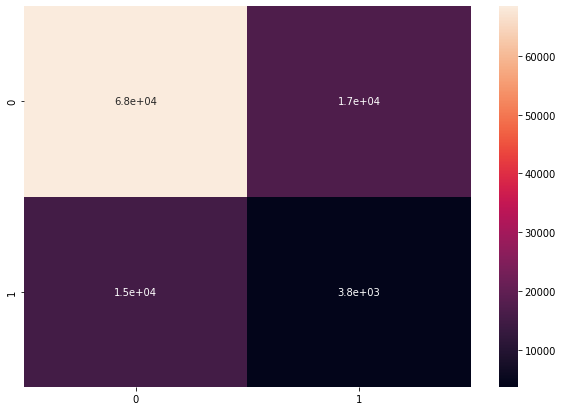

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = post_resample_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


2024/04/16 07:35:56 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


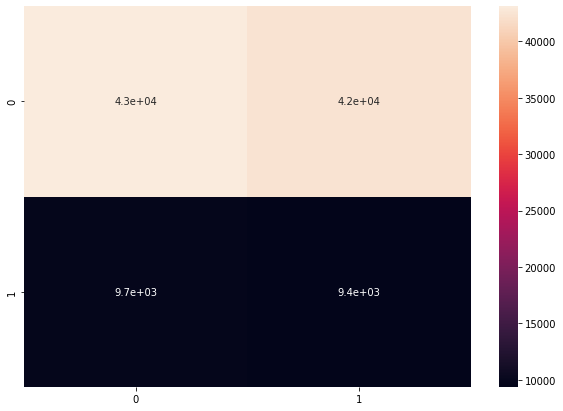

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = logistic_regression_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = svm_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


2024/04/16 07:36:03 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


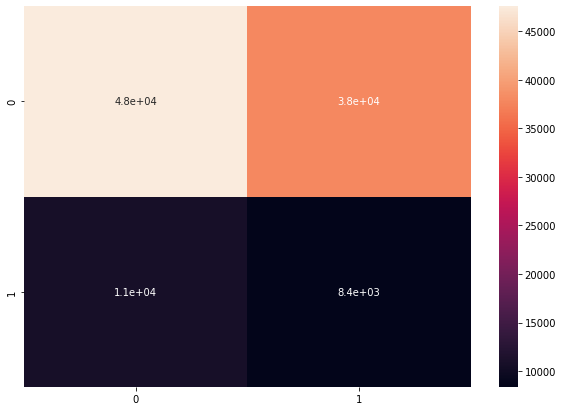

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = knn_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


2024/04/16 07:54:05 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


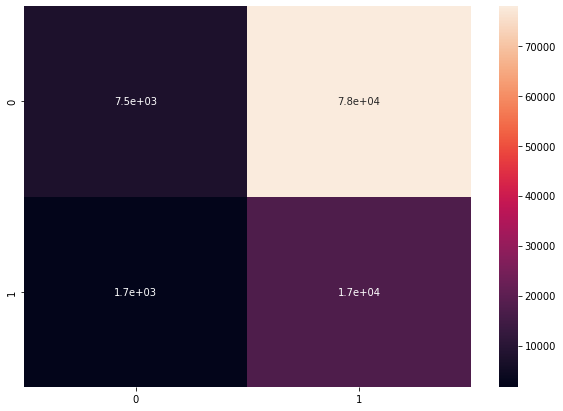

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = naive_bayes_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


2024/04/16 07:54:23 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


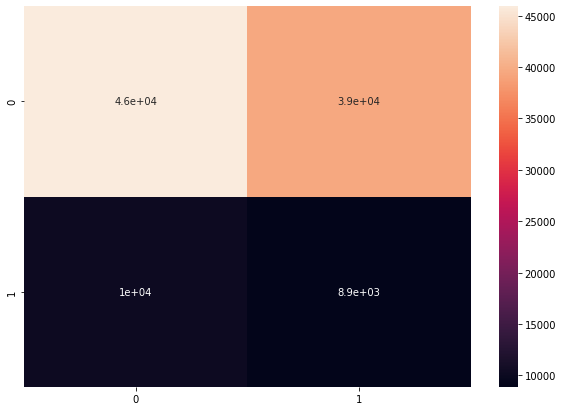

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = decision_tree_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


2024/04/16 07:58:39 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


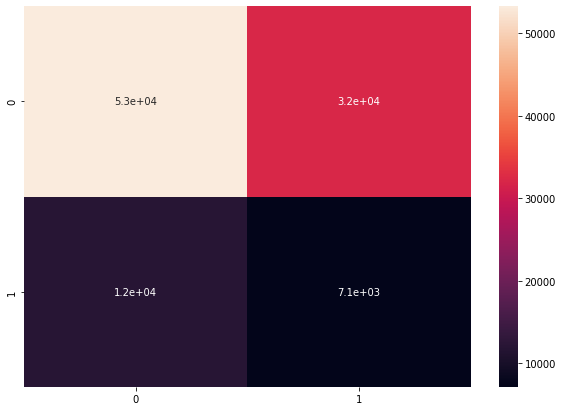

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = gbm_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


[LightGBM] [Info] Number of positive: 192261, number of negative: 199605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 391866, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490629 -> initscore=-0.037487
[LightGBM] [Info] Start training from score -0.037487


2024/04/16 07:58:54 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


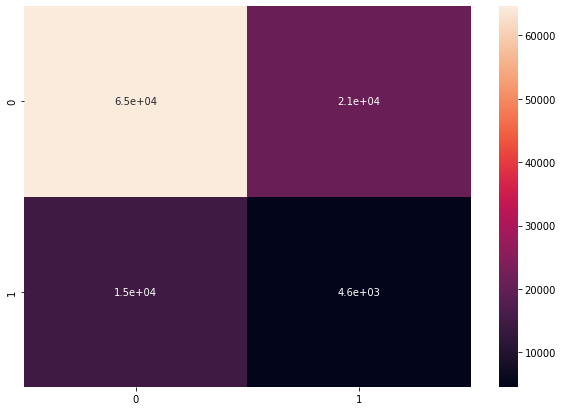

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = lightgbm_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


2024/04/16 07:59:15 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


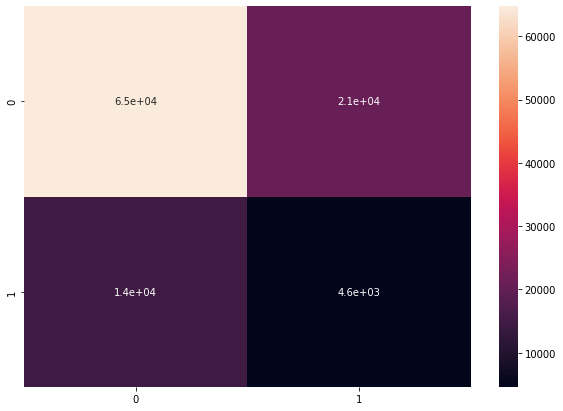

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = xgboost_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


2024/04/16 08:01:41 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


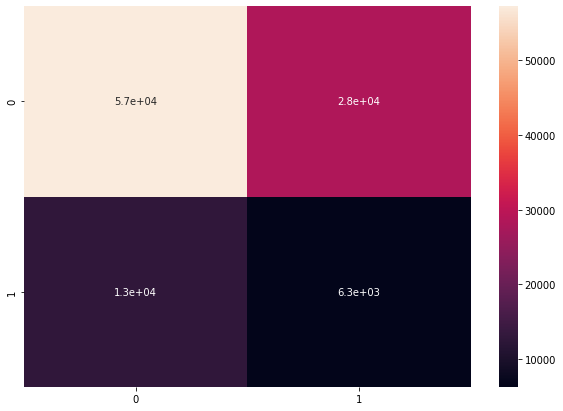

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = catboost_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()


/databricks/python/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
2024/04/16 08:16:52 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.3/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


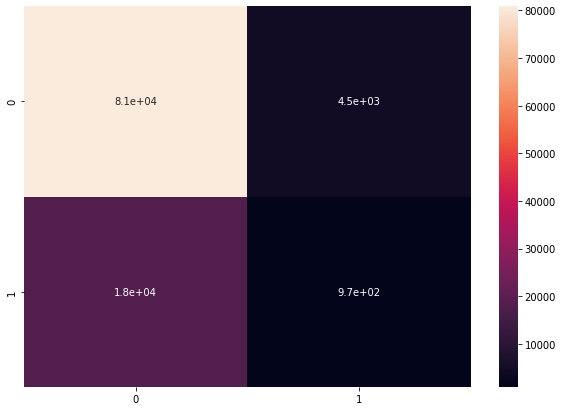

In [0]:
import mlflow
from mlflow import sklearn
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

with mlflow.start_run():
    # Log parameters (if any)
    mlflow.log_param("num_trees", 100)  # Example parameter

    # Fit the model
    trained_pipeline = neural_network_pipeline.fit(resampled_dataframe.drop('Churn', axis=1), resampled_dataframe['Churn'])
    
    # Preprocess the test data using the testing pipeline
    X_test_preprocessed = test_pipeline.transform(test_df)

    # Assuming 'output_column_names' are the names of your processed features
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=output_column_names)

    # Log the model
    mlflow.sklearn.log_model(trained_pipeline, "random_forest_classifier")
    
    # Make predictions
    y_pred = trained_pipeline.predict(X_test_preprocessed_df)
    
    # Create a Series from the predictions, using `test_df.index` to align with the original DataFrame
    predictions_series = pd.Series(y_pred, index=test_df.index, name='Predictions')

    # Concatenate the predictions with the original DataFrame
    result_df = pd.concat([test_df, predictions_series], axis=1)

    # True target values
    true_targets = prediction_df['predicted_probability'] 

    # Predicted values from the model
    predicted_targets = result_df['Predictions']
    
    # Calculate metrics
    accuracy = accuracy_score(true_targets, predicted_targets)
    precision = precision_score(true_targets, predicted_targets)
    recall = recall_score(true_targets, predicted_targets)
    f1 = f1_score(true_targets, predicted_targets)
    conf_matrix = confusion_matrix(true_targets, predicted_targets)
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    

    plt.figure(figsize=(10,7))
    sn.heatmap(conf_matrix, annot=True)
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # End the run
    mlflow.end_run()
